# Advanced ML - HW3

## Flow control parameters

In [ ]:
''' Each parameter can have the values:
  Process - run the process logic and save to disk
  Load - Load saved data from disk
  Disable - Do nothing
'''

GET_RAW_DATA = 'Disable'
PREPROCESS_TEXT = 'Load'
RUN_CLUSTERING = 'Process'


## General parts - imports, load data etc.

### Imports

In [ ]:
from pathlib import Path
from google.colab import drive

import gzip
import json
import pandas as pd
import numpy as np
import string

from tqdm.notebook import tqdm
tqdm.pandas()

from os import cpu_count
import pickle

from langdetect import detect
from langdetect import DetectorFactory
import spacy
from nltk.stem import SnowballStemmer

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans


### Mount drive

In [ ]:
drive.mount('/content/drive')

### Download data, to initial dataframe

#### Initial download from Kaggle - do once

In [ ]:
# ! pip install kaggle
# ! mkdir ~/.kaggle

In [ ]:
# !cp /content/drive/MyDrive/colab_data/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !ls -la ~/.kaggle

# !kaggle datasets download -d allen-institute-for-ai/CORD-19-research-challenge
# !unzip -qq CORD-19-research-challenge.zip -d /content/CORD-19-research-challenge

In [ ]:
# root_path = '/content/CORD-19-research-challenge'

In [ ]:
# metadata = pd.read_csv(root_path + '/metadata.csv')
# metadata = metadata.dropna(subset=["pdf_json_files"])
# metadata = metadata.sort_values(by=["publish_time"], ascending=False)
# metadata = metadata.head(20000)
# metadata.head()

In [ ]:
# def get_article_text(file_path):
      
#       with open(file_path) as file:
#           content = json.load(file)
      
#       full_text = []
#       for entry in content['body_text']:
#           full_text.append(entry['text']) 

#       return '\n'.join(full_text)

In [ ]:
# articles = pd.DataFrame(columns=["title", "cord_uid", "abstract", "full_text"])

# for i, row in metadata.iterrows():

#   article = pd.DataFrame(columns=["title", "cord_uid", "abstract", "full_text"]) 
#   article['title'] = [row["title"]]
#   article['cord_uid'] = [row["cord_uid"]]
#   article['abstract'] = row["abstract"]
#   article['full_text'] = ''
#   article.set_index('cord_uid')
#   if ';' in row["pdf_json_files"]:
#      continue
#   article['full_text'] =  [get_article_text(root_path + '/' + row["pdf_json_files"])]
#   articles = articles.append(article,ignore_index=True)
# articles.head()

In [ ]:
# data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/20k_top_records.zip')
# articles.to_csv(data_path), index=False, compression='zip') 

#### Download ready-made dataframe

In [ ]:
if GET_RAW_DATA == 'Load':
  data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/20k_top_records.zip')
  articles = pd.read_csv(data_path)
  articles.head()

## Preprocess data

### Run preprocess funnel on train data

#### Remove non-english samples


In [ ]:
# Language detection
!pip install langdetect

if PREPROCESS_TEXT == 'Process':
  DetectorFactory.seed = 123

  print("Starting language detection")

  failed = 0
  def get_language(row):
      """Gets the languages of each paper using fancy machine-learning"""
      try:
          return detect(''.join(row[:min(len(row), 50)]))
      except:
          global failed
          failed += 1
          
          # Defaulting to English if failed to detect
          return 'en'


  articles['lang'] = articles['abstract'].progress_apply(get_language)
  articles = articles.drop('lang', axis=1)[articles['lang'] == 'en']

In [ ]:
# Reset DF index
if PREPROCESS_TEXT == 'Process':
  articles.index = range(len(articles.index))

#### Compose text for preprocessing

In [ ]:
  if PREPROCESS_TEXT == 'Process':
    preprocessed_data_col = 'data_preprocessed'
    articles[preprocessed_data_col] = articles.title.fillna('') + ' ' + articles.abstract.fillna('') + ' ' + articles.full_text.fillna('')


#### Remove special chars, concurrent spaces, stop words, change to lower case

In [ ]:
# preprocess functions - different for string / series for performance reasons
def preprocess_text(text):
  if type(text) == str:
    en = spacy.load('en_core_web_sm')
    sw_spacy = en.Defaults.stop_words
    stemmer = SnowballStemmer('english').stem

    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    return ' '.join([stemmer(word) for word in text.split() if word not in sw_spacy])
  
  elif type(text) == pd.core.series.Series:
    en = spacy.load('en_core_web_sm')
    sw_spacy = en.Defaults.stop_words
    stemmer = SnowballStemmer('english').stem

    new_series = text.str.translate(str.maketrans('', '', string.punctuation)).str.lower()
    new_series = new_series.progress_apply(lambda txt: ' '.join([stemmer(word) for word in txt.split() if word not in sw_spacy]))

    return new_series
  
  else:
    raise Exception('Invalid type of text: expected string or Series!')


# #Test functions: 
# print(preprocess_text('What.Ever$#         ! The this is International and Drastically nice @'))
# zz = preprocess_text(pd.Series(['What.Ever$#         ! The this is International and Drastically nice @', 
#                                   'What.EverBBB$#         ! The this is International and Drastically nice @']))
# print(zz[0])
# print(zz[1])

In [ ]:
if PREPROCESS_TEXT == 'Process':
  articles[preprocessed_data_col] = preprocess_text(articles[preprocessed_data_col])

#### Save preprocessed data to disk

In [ ]:
if PREPROCESS_TEXT == 'Process':
  data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/20k_top_records_preprocessed.zip')
  articles.to_csv(data_path, index=False, compression='zip') 

### Load preprocessed data from disk

In [18]:
if PREPROCESS_TEXT == 'Load':
  data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/20k_top_records_preprocessed.zip')
  articles = pd.read_csv(data_path)

### Display preprocessed data

In [19]:
# if PREPROCESS_TEXT != 'Disabled':
articles.head()

,title,cord_uid,abstract,full_text,data_preprocessed
0,COVID-19 Vaccine Priority for People With Neur...,4hcgisuk,NaN,The pandemic illness caused by the severe acut...,covid19 vaccin prioriti peopl neurolog rare di...
1,Biofilm disruption and bactericidal activity o...,s79s2k3k,Background The COVID-19 pandemic has heightene...,Dental handpieces and ultrasonic procedures ha...,biofilm disrupt bactericid activ aqueous ozon ...
2,Social and Economics Aspects of The Pandemic I...,o614th4i,The pandemic has exacerbated a wide range of m...,COVID-19 has an unprecedented impact on the co...,social econom aspect pandem influenc ukrain pa...
3,"A ‘Multiomic’ Approach of Saliva Metabolomics,...",uuh61275,Background and Aims The SARS-CoV-2 pandemic ha...,BACKGROUND AND AIMS: The SARS-CoV-2 pandemic h...,multiom approach saliva metabolom microbiota s...
4,COVID-19 Time Series Forecasting – Twenty Days...,bs206r15,"The new Coronavirus, responsible for the COVID...",One of the most issues addressed in 2020 and 2...,covid19 time seri forecast – day ahead new cor...


## Part 1 - NCD distance function

### We will use NCD to measure distance between compressed documents. Documents will be compressed by Gzip

In [20]:
def k_similar_documents(articles, column_name, document, k):
  ''' Returns a list with two tuples:
  result[0] - the top k similar sample UIDs sorted by distance ascending 
  result[1] - the ncd distance from the reference article '''
  
  ncd_distances = {}
  x_compressed = gzip.compress(document[column_name].encode())
  
  for i, row in articles.iterrows():
    
    if document['cord_uid'] == row['cord_uid']:
      continue
      
    y_compressed = gzip.compress(row[column_name].encode())
    x_y_compressed = gzip.compress((document[column_name] + row[column_name]).encode())
    ncd = (len(x_y_compressed) - min(len(x_compressed), len(y_compressed))) / max(len(x_compressed), len(y_compressed))
    ncd_distances[row['cord_uid']]  = ncd

  return list(zip(*(sorted(ncd_distances.items(), key=lambda item: item[1]))[0:k]))

#### Test run - 5 most similar to the first doc based on preprocessed full text data (Lower NCD is more similar)

In [21]:
num_docs_to_return = 5

preprocessed_data_col = 'data_preprocessed'
top_similar_docs = k_similar_documents(articles, preprocessed_data_col, articles.loc[0], num_docs_to_return)

results = articles[articles['cord_uid'].isin(top_similar_docs[0])].copy()
results['ncd_distance'] = top_similar_docs[1]
results.head(10)

,title,cord_uid,abstract,full_text,data_preprocessed,ncd_distance
423,Importance of understanding the reinfection ri...,hapog50d,NaN,The Article by Anna A Mensah and colleagues 1 ...,import understand reinfect risk covid19 childr...,0.869260
7867,Editorial: COVID-19 in CNS and PNS: Basic and ...,nu51pn3s,NaN,The COVID-19 pandemic has had significant impl...,editori covid19 cns pns basic clinic focus mec...,0.870239
9440,Special Issue “Pulmonary and Critical Care Pra...,h711skwa,Severe acute respiratory syndrome coronavirus-...,Severe acute respiratory syndrome coronavirus-...,special issu “pulmonari critic care practic pa...,0.875403
10917,Nicotinamide adenine dinucleotide fluorescence...,os19gm8d,NaN,Coronavirus disease 2019 (COVID-19) revealed m...,nicotinamid adenin dinucleotid fluoresc assess...,0.875542
10948,Need to update cardiological guidelines to pre...,mxuuen6h,NaN,Novel coronavirus disease caused by severe acu...,need updat cardiolog guidelin prevent covid19 ...,0.877986


## Part 2  - Similar documents finder
* In this part, we implemented a related doc finder that gets a text string and finds the most related N documents.
* The algorithm consists of two steps:
  1.  TF/IDF K-means clustering
  2.  NCD similarity within closest cluster



### Training: TF/IDF K-means clustering and visualizations

#### Vectorize data

In [22]:
data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/tfidf_model.pickle')

if RUN_CLUSTERING == 'Process':
  tfidf = TfidfVectorizer(min_df = 5, max_df = 0.95)
  tfidf.fit(articles[preprocessed_data_col])

  with open(data_path, 'wb') as handle:
    pickle.dump(tfidf, handle)

elif RUN_CLUSTERING == 'Load':
  with open(data_path, 'rb') as handle:
    tfidf = pickle.load(handle)


vectorized_data = tfidf.transform(articles[preprocessed_data_col])
print(f'Vectorized data shape: {vectorized_data.shape}')

Vectorized data shape: (17599, 80867)


#### decide on number of clusters for TF/IDF

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0.5, 1.0, 'SSE by Cluster Center Plot')

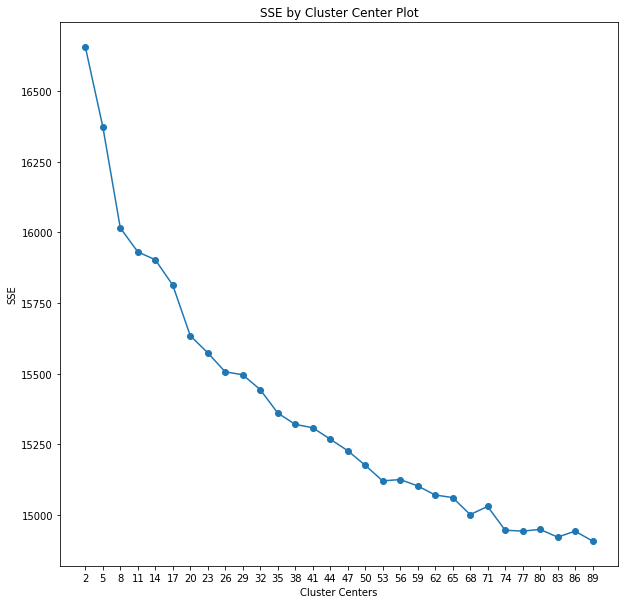

In [23]:
if RUN_CLUSTERING == 'Process':
  def kmeans_sse(data, max_k, step):
    # iterate on K value for K-Means and calculate SSE
      iters = range(2, max_k+(step-1), step)
      sse = []
      for k in tqdm(iters):
          sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
      
      return iters, sse


  # Run and plot
  x, sse = kmeans_sse(vectorized_data, 90, 3)
  
  data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/cluster_visualization_x.pickle')
  with open(data_path, 'wb') as handle:
    pickle.dump(x, handle)
  
  data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/cluster_visualization_sse.pickle')
  with open(data_path, 'wb') as handle:
    pickle.dump(sse, handle)


elif RUN_CLUSTERING == 'Load':
  data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/cluster_visualization_x.pickle')
  with open(data_path, 'rb') as handle:
    x = pickle.load(handle)
  
  data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/cluster_visualization_sse.pickle')
  with open(data_path, 'rb') as handle:
    sse = pickle.load(handle)


f, ax = plt.subplots(1, 1)
f.set_size_inches(10, 10)
ax.plot(x, sse, marker='o')
ax.set_xlabel('Cluster Centers')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_ylabel('SSE')
ax.set_title('SSE by Cluster Center Plot')

#### Cluster data and plot results in 2D

In [24]:
data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/kmeans_model.pickle')

if RUN_CLUSTERING == 'Process':
  N_CLUSTERS = 16 # number of clusters selected
  kmeans_model = MiniBatchKMeans(n_clusters=N_CLUSTERS, init_size=1024, batch_size=2048, random_state=20).fit(vectorized_data)

  with open(data_path, 'wb') as handle:
    pickle.dump(kmeans_model, handle)

elif RUN_CLUSTERING == 'Load':
  with open(data_path, 'rb') as handle:
    kmeans_model = pickle.load(handle)


# add clusters to dataframe
clusters = kmeans_model.predict(vectorized_data)
articles['cluster'] = clusters

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


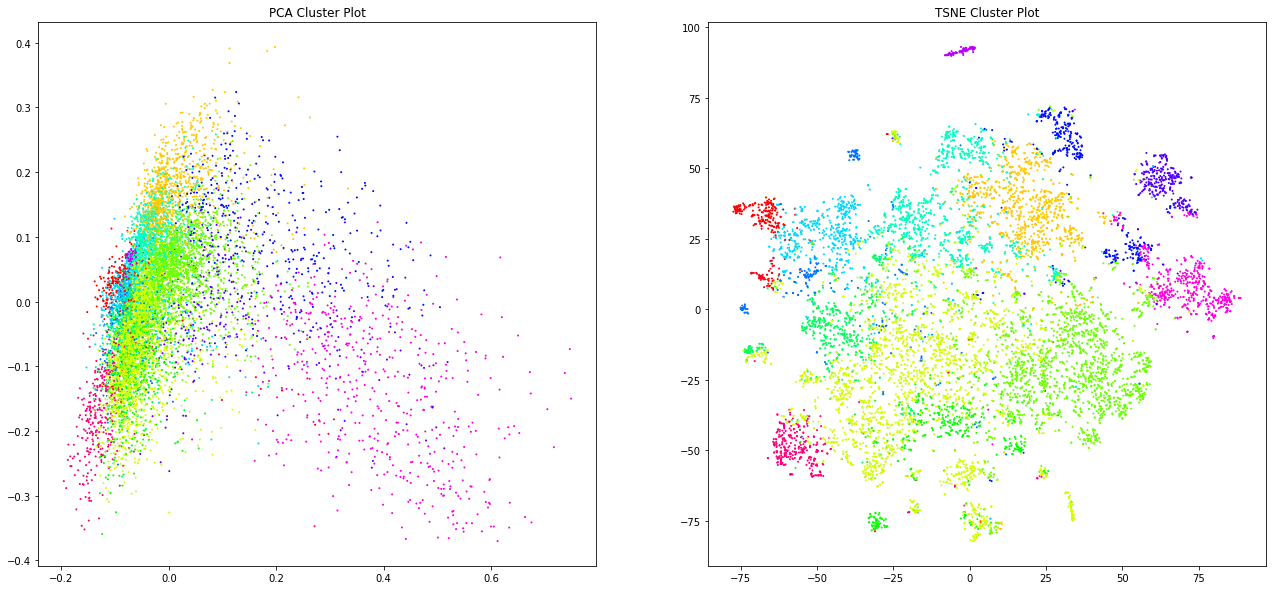

In [25]:
def plot_tsne_pca(data, labels):
    NUM_SAMPLES = 10000
    max_label = max(labels)
    samples = np.random.choice(range(data.shape[0]), size=NUM_SAMPLES, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[samples,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[samples,:].todense()))
    
    idx = np.random.choice(range(pca.shape[0]), size=NUM_SAMPLES, replace=False)
    label_subset = labels[samples]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(22, 10))

    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset, s=1)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset, s=1)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(vectorized_data, clusters)

### Inference - similar text finder

#### Inference function for similar text lookup

In [26]:
def find_similar_texts(input_text, preprocessed_corpus, num_results, tfidf_model):
  preprocessed_data_col = 'data_preprocessed'

  # preprocess input text
  input_text_prep = preprocess_text(input_text)

  # wrap input text in pandas for use with similarity function
  input_text_df = pd.DataFrame([['Input', input_text_prep]], columns=['cord_uid', preprocessed_data_col])

  # vectorize input text
  input_text_vectorized = tfidf_model.transform([input_text_prep])
  print(f'Vectorized data shape: {input_text_vectorized.shape}')

  # find cluster for input text sample
  input_cluster = kmeans_model.predict(input_text_vectorized)[0]
  print (f'Input cluster: {input_cluster}')

  # find docs with same cluster as input
  relevant_cluster_articles = articles[articles.cluster == input_cluster]

  # find N most similar docs withion cluster
  top_similar_docs = k_similar_documents(relevant_cluster_articles, preprocessed_data_col, input_text_df.loc[0], num_results)

  results = articles[articles['cord_uid'].isin(top_similar_docs[0])].copy()
  results['ncd_distance'] = top_similar_docs[1]
  return results



#### Test

In [27]:
# input_text = articles.full_text[35]
tfidf_model = tfidf


input_text = '''
  ary to evaluate the effect of anti-epidemic bonds to stimulate market vitality and achieve the epidemic control goal as soon as possible. Nozawa and Qiu (2021) document that the 
  rising default risk of firms that face cash shortfalls due to the outbreak is a key concern among the major issues facing the economy; thus, liquidity support offered by anti-epidemic 
  bonds can mitigate risk and instill confidence in the market. Based on the above, our study focuses on a nascent rise in anti-epidemic bonds in China and examines the stock market reaction 
  of anti-epidemic bonds. First, we calculate the abnormal s the COVID-19 pandemic mainly focuses on quantitative easing monetary policy (O'Hara and Zhou, 2021; D'Amico et al., 2020; Nozawa and Qiu, 2021) . 
   This paper contributes to the nascent literature by exploiting the market-based epidemic control policy in the largest developing economy, which also suffers the outbreak first. This paper also complements international findings 
   about stock market reactions to special bonds, such as green bonds (Wang et al., 2020) , and new perspectives about bond spillover effects on the stock market (Reboredo , 2018) by dissecting stock market reactions to anti-epidemic bond 
   issuance announcements. Determined by the issuance of the first anti-epidemic corporate bond in February 2020, the antiepidemic corporate bond sample data are from February 2020 to December 2021. We collect all bond data with an anti-epidemic 
   flag and match the bond characteristics, firm information and stock trading data from the Wind database. The initial anti-epidemic bond sample comprises 800 bonds. To examine the reaction of the stock market, we focus on bonds issued by listed 
   companies in the Chinese stock market. There are 179 anti-epidemic bonds issued by 122 listed corporates among the initial sample. For these anti-epidemic bond issuers, we extract all conventional bond issuance announcements from 2018 to 2021 and then 
   delete convertible bonds, exchangeable bonds, subordinated bonds, commercial bank bonds and nt date of a bond issue (t=0) and use [-5, 5] as the event window. We calculate cumulative abnormal return
     (CAR) using a market model (with Shanghai and Shenzhen 300 index as the market factor). The average abnormal return (AAR) and cumulative abnormal return (CAR) are calculated based on the existing literature 
     c productivity and global resource efficiency, strengthening the capacity of domestic financial institutions and promoting aspects of SDG 8. Two papers address monitoring and measurement of SDG 8, i.e. the development 
     of a proposal for new sub-goals, targets and indicators from a degrowth perspective and the development of a nowcasting approach for indicators assigned to SDG 8. Other aspects addressed in this special issue include an assessment of the 
     potential of different labor market policies for greening employment and an econometric analysis at the intersection of SDG 8 with energy efficiency (SDG 7), technological change (SDG 9) and climate change (SDG 13) that focuses on the
      determinants and effects of the adoption of "green energy saving and related technologies" (GETs). In the first paper of this special issue, Kreinin and Aigner (2021) propose  The authors analyze the goal from 
      the perspective of "strong sustainability" (e.g. Ayres et al. 2001 ) and provide a reformulated framework including new sub-goals, targets and indicators, which they argue being better in line with the overall goals of the SDGs and the 
      Agenda 2030. In their work, they peel out and discuss aspects of SDG 8 which are currently interfering the idea of long-term social-ecological sustainability. Their approach differentiates itself more clearly from economic growth and
       productivity per se and rather focuses on aspects of social and environmental well-being, decency of work and dependence of economic growth and unsustainable work. Evaluating the progress of the SDGs provides important information for policy
'''


In [28]:
find_similar_texts(input_text, articles, 5, tfidf_model)


Vectorized data shape: (1, 80867)
Input cluster: 6


,title,cord_uid,abstract,full_text,data_preprocessed,cluster,ncd_distance
709,"Special Issue: Sustainability, Work and Growth...",i5gsdyg5,NaN,"Following the workshop ""Sustainability, Work a...",special issu sustain work growth context sdg 8...,6,0.694830
2961,Recent progress in modelling and simulation te...,9qi2lt3x,NaN,HVAC design process (Wang et al. 2022a) . A pa...,recent progress model simul technolog energi e...,6,0.771789
3667,Entrepreneurial responses to uncertainties dur...,v6y56fe0,The COVID-19 pandemic has brought sweeping cha...,learning to grapple with uncertainty (Williams...,entrepreneuri respons uncertainti covid19 reco...,6,0.887246
4862,Many hands make light work: Evidence from Chin...,2los9wko,"Based on China’s anti-epidemic bond data, this...","Since early 2020, the outbreak and rapid sprea...",hand light work evid china antiepidem bond bas...,6,0.894640
8510,Public health institutes and the fight against...,0xiqxc7h,NaN,NPHIs are science-based organisations operatin...,public health institut fight climat chang nphi...,6,0.896490


# Experiments and snippets

In [29]:
# # Calculate compressed doc length

# num_articles = len(articles)

# data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/doc_compressed_len.npy')
# if data_path.is_file():
#   doc_compressed_len = np.load(data_path)

# else:
#   # Compress each document by its own, store length of compression
#   print('Calculating compressed len per document:')
#   doc_compressed_len = np.zeros(num_articles, dtype='int16')
  
#   with tqdm(total = len(articles)) as progress_bar:
#     for x, article_x in articles.iterrows():
#       doc_compressed_len[x] = len(gzip.compress(article_x['full_text'].encode()))
#       progress_bar.update(1)
  
#   data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/doc_compressed_len.npy')
#   np.save(data_path, doc_compressed_len)



In [ ]:
# # Calculate distance matrix

# print('Calculating distance matrix:')
# data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/ncd_dist_matrix.npy')
# if data_path.is_file():
#   ncd_dist_matrix = np.load(data_path)
# else:
#   ncd_dist_matrix = np.zeros([num_articles, num_articles], dtype='float64')   # needed first time only

# new_data_calculated = False

# with tqdm(total = len(articles)) as progress_bar:
#   for x, article_x in articles.iterrows():   
#     for y, article_y in articles.iterrows():     
#       if ((x <= y) and ncd_dist_matrix[x, y] == 0):
#         x_y_compressed = gzip.compress((article_x['full_text'] + article_y['full_text']).encode())
      
#         ncd_dist_matrix[x, y] = (len(x_y_compressed) - min(doc_compressed_len[x], doc_compressed_len[y])) / max(doc_compressed_len[x], doc_compressed_len[y])
#         ncd_dist_matrix[y, x] = ncd_dist_matrix[x, y]
#         new_data_calculated = True
  
#     if (new_data_calculated and (x % 10 == 0)):
#       np.save(data_path, ncd_dist_matrix)

#     progress_bar.update(1)


Calculating distance matrix:


  0%|          | 0/17599 [00:00<?, ?it/s]

In [ ]:
##################################################################

In [ ]:
# def calc_doc_distance(x, y):
#   x_compressed = gzip.compress(x['full_text'].encode())
#   y_compressed = gzip.compress(y['full_text'].encode())
#   x_y_compressed = gzip.compress((x['full_text'] + y['full_text']).encode())
  
#   ncd = (len(x_y_compressed) - min(len(x_compressed), len(y_compressed))) / max(len(x_compressed), len(y_compressed))
#   return ncd

In [ ]:
# calc_doc_distance(articles.loc[220], articles.loc[220])